# Data Exploration and System Management using AI/ML

## Anomaly Detection in the Wholesale Customer data using PCA and One-Class SVM

## Mahesh Sadupalli(4034007)

In [1]:
# Step 1: Import the necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [2]:
# Step 2: Load the data file
data = pd.read_csv('Wholesale customers data.csv')

# to display the first few rows of the dataset
print("Head of the dataset:")
print(data.head())

Head of the dataset:
   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185


In [3]:
# Step 3: Log Transformation to Reduce Skewness
# Apply log transformation with an offset to handle zero and small values
log_offset = 10
columns_to_transform = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
data[columns_to_transform] = np.log(data[columns_to_transform] + log_offset)

In [4]:
# Step 4: Scale Data
# Standardize the features to have a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[columns_to_transform])

Correlation matrix:
                     Fresh      Milk   Grocery    Frozen  Detergents_Paper  \
Fresh             1.000000 -0.026847 -0.133421  0.395511         -0.171495   
Milk             -0.026847  1.000000  0.769463 -0.054522          0.681495   
Grocery          -0.133421  0.769463  1.000000 -0.163782          0.801659   
Frozen            0.395511 -0.054522 -0.163782  1.000000         -0.219043   
Detergents_Paper -0.171495  0.681495  0.801659 -0.219043          1.000000   
Delicassen        0.259731  0.360013  0.257888  0.262367          0.169825   

                  Delicassen  
Fresh               0.259731  
Milk                0.360013  
Grocery             0.257888  
Frozen              0.262367  
Detergents_Paper    0.169825  
Delicassen          1.000000  


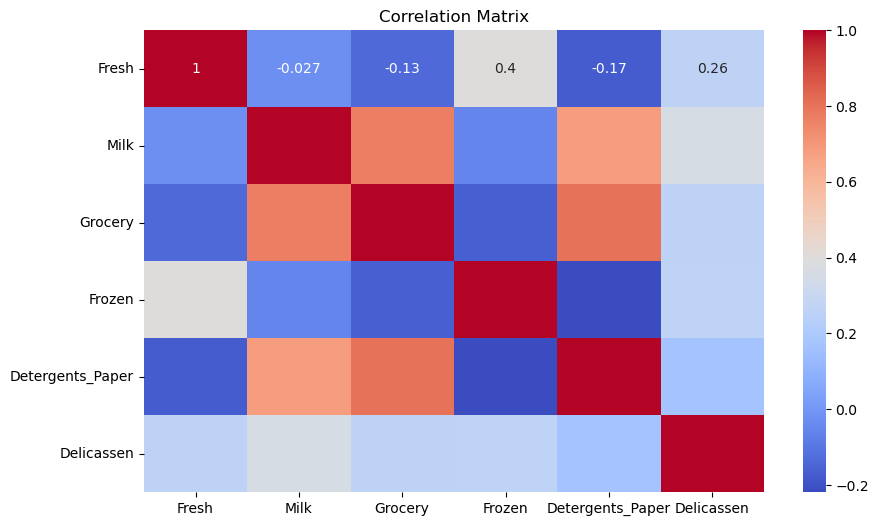

In [5]:
# Step 5: Correlation Analysis
# Compute and visualize the correlation matrix for the original dataset
print("Correlation matrix:")
correlation_matrix = data[columns_to_transform].corr()
print(correlation_matrix)
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

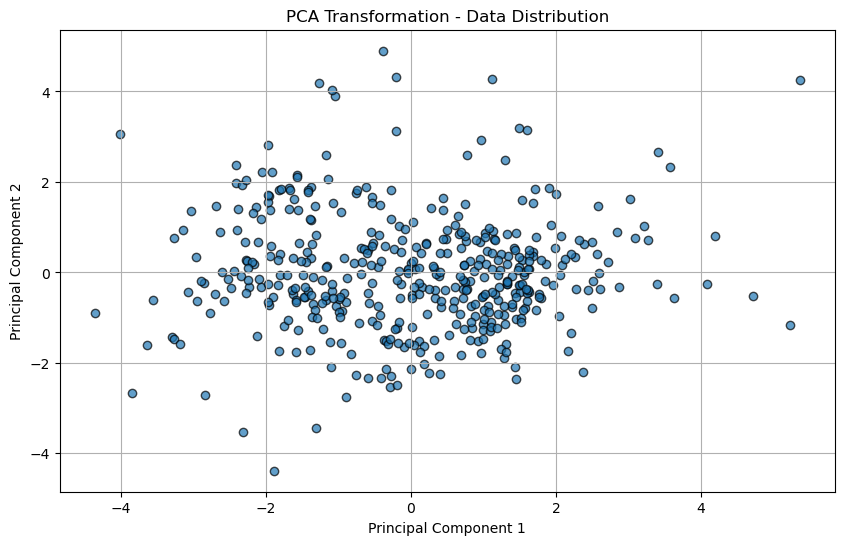

In [6]:
# Step 6: Principal Component Analysis (PCA)
# Perform PCA to reduce the dimensionality of the dataset
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
data_pca_df = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])

# Visualize PCA Transformation
plt.figure(figsize=(10, 6))
plt.scatter(data_pca_df['PC1'], data_pca_df['PC2'], alpha=0.7, edgecolor='k')
plt.title("PCA Transformation - Data Distribution")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


Number of anomalies detected: 30


<Figure size 1000x600 with 0 Axes>

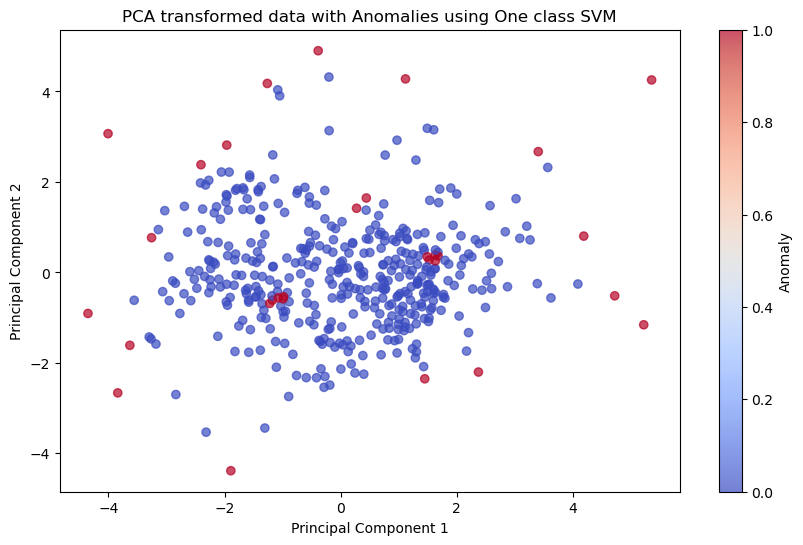

In [7]:
# Step 7: One-Class SVM for Anomaly Detection
# Train a One-Class SVM model to detect anomalies
# Train a One-Class SVM model to detect anomalies based on the PCA-transformed data
# This method identifies points that deviate significantly from the majority as anomalies
svm_model = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
svm_model.fit(data_pca)

# Create a separate dataframe for anomaly-related information
anomaly_info = pd.DataFrame({
    'Anomaly_Score': svm_model.decision_function(data_pca),
    'Anomaly': svm_model.predict(data_pca),
    'Anomaly_Score': svm_model.decision_function(data_pca),  # Scores indicating how anomalous each point is
    'Anomaly': svm_model.predict(data_pca)  # Labels: -1 = anomaly, 1 = normal
})

# Map anomalies: -1 = anomaly, 1 = normal
anomaly_info['Anomaly'] = anomaly_info['Anomaly'].map({1: 0, -1: 1})

# Count anomalies
anomalies_count = anomaly_info['Anomaly'].sum()
print(f"Number of anomalies detected: {anomalies_count}")

# Visualize anomalies
# Red points represent anomalies, blue points represent normal data
plt.figure(figsize=(10, 6))
plt.figure(figsize=(10, 6))
plt.scatter(data_pca_df['PC1'], data_pca_df['PC2'], c=anomaly_info['Anomaly'], cmap='coolwarm', alpha=0.7)
plt.title("PCA transformed data with Anomalies using One class SVM")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Anomaly")
plt.show()

In [8]:
# Step 8: Splitting Data for Benchmark Tests
# Split the data into training and testing sets using only PCA components
X = data_pca_df[['PC1', 'PC2']]
X_train, X_test, y_train, y_test = train_test_split(X, data['Fresh'], test_size=0.2, random_state=42)

In [9]:
# Step 9: Train Linear Regression as Benchmark Model
# Fit a Linear Regression model to the training data
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [10]:
# Step 10: Benchmark Tests
# Generate predictions on training and testing sets
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

In [11]:
# Compute evaluation metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)
train_mae = mean_absolute_error(y_train, train_preds)
test_mae = mean_absolute_error(y_test, test_preds)

In [12]:
# Display evaluation metrics
print("Training RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Training R2:", train_r2)
print("Test R2:", test_r2)
print("Training MAE:", train_mae)
print("Test MAE:", test_mae)

Training RMSE: 0.8643433547873907
Test RMSE: 1.0169865731755983
Training R2: 0.6062520050412439
Test R2: 0.5939057346691992
Training MAE: 0.6580451496999302
Test MAE: 0.7575917530083671


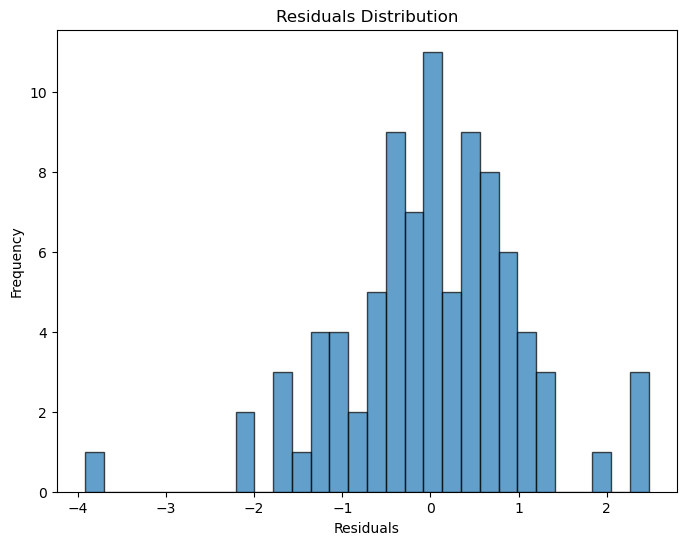

In [13]:
# Step 11: Residual Analysis
# Plot the distribution of residuals
residuals = y_test - test_preds
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

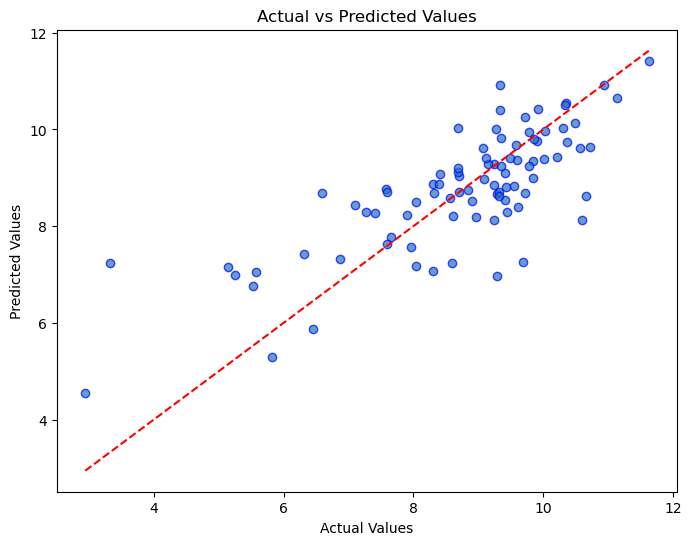

In [14]:
# Step 12: Visualize Predictions
# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, test_preds, alpha=0.7, edgecolors='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

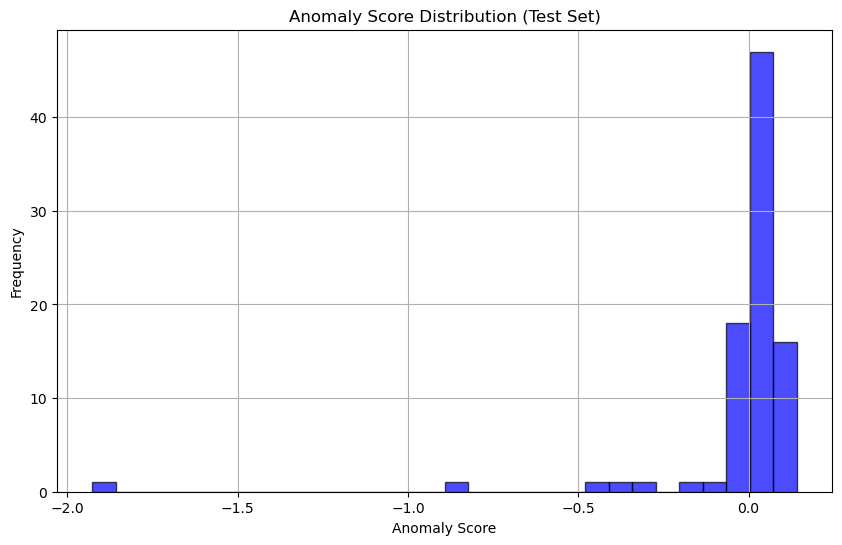

In [15]:
# Benchmark Test for Anomalies (One-Class SVM)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Split the PCA-transformed data into training and testing sets
X_train, X_test = train_test_split(data_pca, test_size=0.2, random_state=42)

# Train the One-Class SVM on the training set
svm_model = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
svm_model.fit(X_train)

# Predict anomalies on the test set and calculate anomaly scores
test_predictions = svm_model.predict(X_test)  # -1 for anomalies, 1 for normal
test_anomaly_scores = svm_model.decision_function(X_test)

# Visualize the distribution of anomaly scores for the test set
plt.figure(figsize=(10, 6))
plt.hist(test_anomaly_scores, bins=30, edgecolor='k', alpha=0.7, color='blue')
plt.title("Anomaly Score Distribution (Test Set)")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


This project demonstrated the value of combining exploratory data analysis, dimensionality reduction, and anomaly detection techniques for uncovering patterns and outliers in wholesale customer data. The use of PCA and One-Class SVM proved effective for simplifying the data and identifying anomalies, respectively. 